[2, 5, 10, 11]


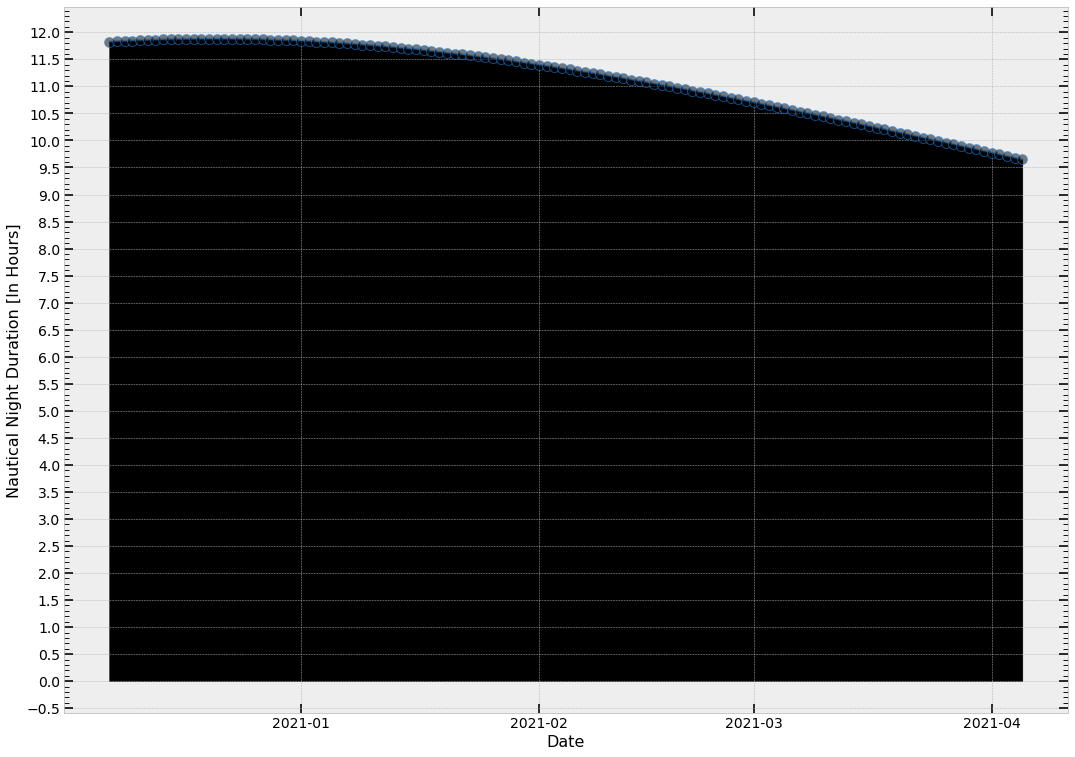

In [3]:
#!/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx----------CALCULATION OF TWILIGHT TIMES AND NIGHT DURATION---------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #


# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import ephem
import numpy as np
import pandas as pd
import easygui as eg
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DateFormatter, MonthLocator

plt.style.use('bmh')
plt.rc('font', family='sans-serif')
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
list_telescopes = 'TelescopeList.dat'

dict_twilights = {'Civil': ['-6', True], 'Nautical': ['-12', True], 'Astronomical': ['-18', True],
                  'Sunset/Sunrise': ['-0.34', False], 'Moonset/Moonrise': ['-0.34', False]}
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Manual Setup - GUI Code
# ------------------------------------------------------------------------------------------------------------------- #
# Telescope Details
telescope = eg.enterbox(msg='Enter The Name of the Telescope', title='Name of the Telescope', default='DOT')
telescope_df = pd.read_csv(list_telescopes, sep='\s+', comment='#').set_index('ShortName')

if telescope in telescope_df.index.values:
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE, _, _) = telescope_df.loc[telescope].values
else:
    telescope = eg.multenterbox('Enter the Necessary Details of the Telescope', title='Details of the Telescope',
                                fields=['Name', 'Longitude', 'Latitude', 'Altitude', 'TimeZone'],
                                values=telescope_df.loc['DOT'].values)
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE) = telescope

# Range of Dates for which Twilight Times have to be calculated
date_start = str(Time(Time.now(), format='iso', out_subfmt='date'))
date_end = str(Time(date_start, format='iso', out_subfmt='date') + 120 * u.d)
daterange = eg.multenterbox('Enter the Time Duration for which the Twilight Times need to be computed',
                            title='Time Duration', fields=['Date Start', 'Date End'], values=[date_start, date_end])

# Choose which columns to be printed to the output file
list_printcols = ['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical', 'DawnNautical',
                  'DawnCivil', 'Sunrise', 'Moonrise', 'Moonset', 'NightDuration', 'MoonIllumination']
printcols = eg.multchoicebox('Choose the Appropriate Columns for the Output file', title='Output Columns',
                             choices=list_printcols, preselect=[2, 5, 10, 11])

# Plot Times in UTC or Local Time?
utc = eg.boolbox(msg='Plot Times in UTC or Local Time?', title='UTC Or Local Time?', choices=['UTC', 'Local Time'])
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Declaring Object 'telescope'
# ------------------------------------------------------------------------------------------------------------------- #
telescope = ephem.Observer()
telescope.pressure = 0
telescope.lon = OBS_LONG
telescope.lat = OBS_LAT
telescope.elevation = OBS_ALT
telescope.epoch = ephem.J2000
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculate Sunset, Sunrise and Twilight Times
# ------------------------------------------------------------------------------------------------------------------- #

def calculate_twilighttime(category='Sunset/Sunrise'):
    """
    It will compute Rising and Setting times for the twilight time specified by 'twilight'.
    Args:
        category : Specifies which Twilight times have to be coomputed
    Returns:
        setting  : Setting time for the twilight
        rising   : Rising time for the twilight
    """
    telescope.horizon = dict_twilights[category][0]
    setting = telescope.previous_setting(ephem.Sun(), use_center=dict_twilights[category][1])
    rising = telescope.next_rising(ephem.Sun(), use_center=dict_twilights[category][1])

    return setting, rising


def calculate_moontime(time_midnight):
    """
    It will compute Moonrise and Moonset times.
    Args:
        time_midnight : Midnight time for the date on which Moonrise and Moonset is to be computed
    Returns:
        rising        : Time of Moonrise
        setting       : Time of Moonset
    """
    category = 'Moonset/Moonrise'
    telescope.horizon = dict_twilights[category][0]

    previousrise = telescope.previous_rising(ephem.Moon(), use_center=dict_twilights[category][1])
    previousset = telescope.previous_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextset = telescope.next_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextrise = telescope.next_rising(ephem.Moon(), use_center=dict_twilights[category][1])

    if previousrise.datetime() > previousset.datetime():
        rising = previousrise
        setting = nextset
    if time_midnight - previousset.datetime() > nextrise.datetime() - time_midnight:
        rising = nextrise
        setting = nextset
    else:
        rising = previousrise
        setting = previousset

    return rising, setting


def get_twilighttimes(time_df, date_obs):
    """
    Obtain Sunset, Sunrise and Twilight times for the observatory on a given date 'date_obs'.
    Args:
        time_df  : Input Pandas DataFrame to which twilight times have to be appended
        date_obs : Date of observation for which twilight times have to be computed
    Returns:
        time_df  : Output Pandas DataFrame to which twilight times have been appended
    """
    time_prevnight = (Time(date_obs) - abs(OBS_TIMEZONE) * u.hour).datetime
    time_midnight = (Time(date_obs) + 1 * u.day - abs(OBS_TIMEZONE) * u.hour).datetime
    telescope.date = time_midnight

    # Calculation Of Local MoonRise & MoonSet [Refraction Correction Of Moon = -0.34 Degrees]
    moon_rise, moon_set = calculate_moontime(time_midnight)

    # Calculation Of Local Sunset & Sunrise [Refractrion Correction for Sun = -0.34 Degrees]
    sun_set, sun_rise = calculate_twilighttime('Sunset/Sunrise')

    # Calculation Of Civil Twilight [Elevation Of Sun = -6 Degrees]
    dusk_civil, dawn_civil = calculate_twilighttime('Civil')

    # Calculation Of Nautical Twilight [Elevation Of Sun = -12 Degrees]
    dusk_nauti, dawn_nauti = calculate_twilighttime('Nautical')

    # Calculation Of Astronomical Twilight [Elevation Of Sun = -18 Degrees]
    dusk_astro, dawn_astro = calculate_twilighttime('Astronomical')

    # Calculation of Maximum Illumination of Moon During the Night
    list_moonphases = []
    for time in np.arange(time_prevnight, time_midnight, timedelta(minutes=15)).astype(datetime):
        time = datetime.strftime(time, '%Y/%m/%d %H:%M:%S')
        list_moonphases.append(ephem.Moon(time).phase)

    nightduration = str(dawn_nauti.datetime() - dusk_nauti.datetime()).split('.')[0]
    moonphase = '{0:.2f}'.format(np.max(list_moonphases))
    
    if utc:
        twilighttimes = [datetime.strftime(time.datetime(), '%H:%M:%S') for time in
                         [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                          dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
    else:
        twilighttimes = [datetime.strftime(time.datetime() + timedelta(hours=OBS_TIMEZONE), '%H:%M:%S')
                         for time in [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                                      dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]

    dict_columns = {'Sunset': 0, 'DuskCivil': 1, 'DuskNautical': 2, 'DuskAstronomical': 3, 'DawnAstronomical': 4,
                    'DawnNautical': 5, 'DawnCivil': 6, 'Sunrise': 7, 'Moonrise': 8, 'Moonset': 9, 
                    'NightDuration': nightduration, 'MoonIllumination': moonphase}

    for column, index in dict_columns.items():
        date_obs = str(Time(date_obs, format='iso', out_subfmt='date'))
        if type(index) == int:
            time_df.loc[date_obs, column] = twilighttimes[index]
        else:
            time_df.loc[date_obs, column] = index

    return time_df

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculate the Twilight Times for the Range of Dates
# ------------------------------------------------------------------------------------------------------------------- #
[datestart, dateend] = daterange
localdate_duration = np.arange(Time(datestart), Time(dateend), 1 * u.d)

twilight_df = pd.DataFrame()
plot = pd.DataFrame()
for localdate in localdate_duration:
    twilight_df = get_twilighttimes(twilight_df, localdate)

twilight_df = twilight_df[printcols]
twilight_df.index.name = 'Date'
twilight_df.to_csv('TwilightTimes_{0}To{1}'.format(datestart, dateend), sep='\t')
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plot Night Duration as a Function of Date of Observation
# ------------------------------------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(18, 13))
ax = fig.add_subplot(111)

dates = [datetime.strptime(x, '%Y-%m-%d') for x in twilight_df.index.values]
nightlength = [(datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds() / 3600
               for x in twilight_df['NightDuration']]

ax.plot(dates, nightlength, ls='-', lw=2, marker='o', mfc='k', ms=10, c='dodgerblue', alpha=0.5)
ax.fill_between(dates, nightlength, color='k')

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=14)
ax.tick_params(axis='both', which='minor', direction='in', width=0.9, length=5, labelsize=14)

ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Nautical Night Duration [In Hours]', fontsize=16)

# fig.savefig('NightDuration_{0}To{1}.pdf'.format(datestart, dateend), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

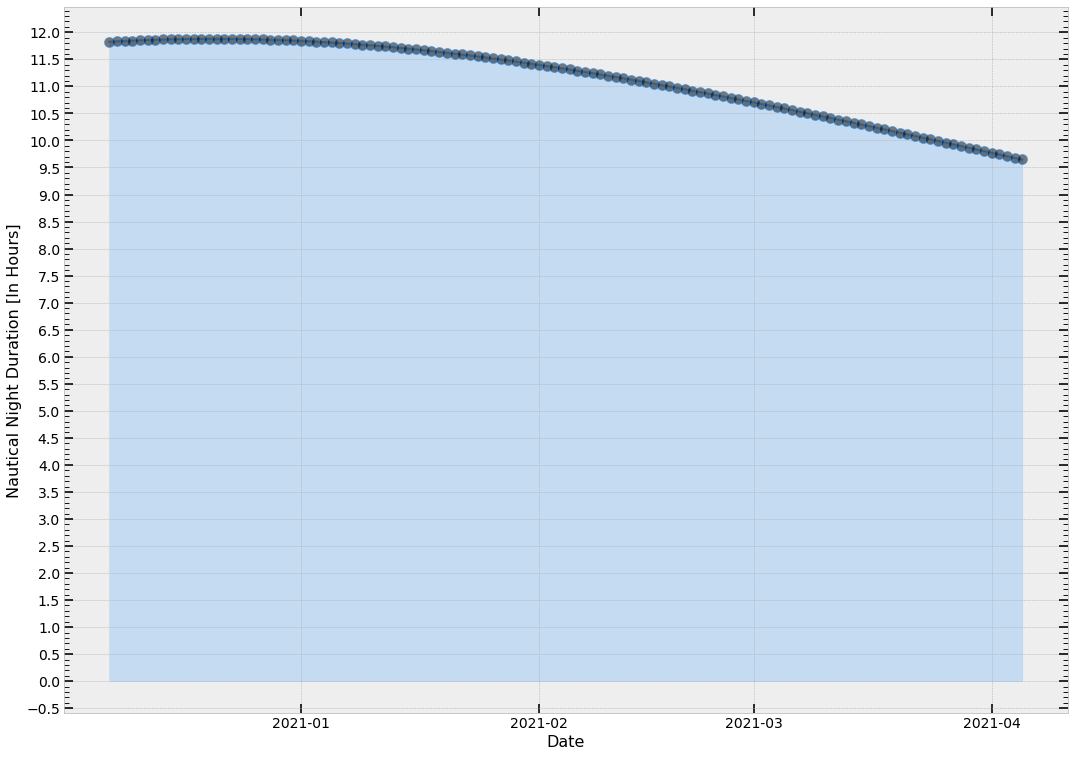

In [5]:

# ------------------------------------------------------------------------------------------------------------------- #
# Plot Night Duration as a Function of Date of Observation
# ------------------------------------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(18, 13))
ax = fig.add_subplot(111)

dates = [datetime.strptime(x, '%Y-%m-%d') for x in twilight_df.index.values]
nightlength = [(datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds() / 3600
               for x in twilight_df['NightDuration']]

ax.plot(dates, nightlength, ls='-', lw=2, marker='o', mfc='k', ms=10, c='dodgerblue', alpha=0.5)
ax.fill_between(dates, nightlength, color='dodgerblue', alpha=0.2)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=14)
ax.tick_params(axis='both', which='minor', direction='in', width=0.9, length=5, labelsize=14)

ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Nautical Night Duration [In Hours]', fontsize=16)

# fig.savefig('NightDuration_{0}To{1}.pdf'.format(datestart, dateend), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

In [20]:
#!/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx-------------------------NIGHT SKY PLANNER-------------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #


# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import ephem
import numpy as np
import pandas as pd
import easygui as eg
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
list_telescopes = 'TelescopeList.dat'

dict_twilights = {'Civil': ['-6', True], 'Nautical': ['-12', True], 'Astronomical': ['-18', True],
                  'Sunset/Sunrise': ['-0.34', False], 'Moonset/Moonrise': ['-0.34', False]}
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Manual Setup - GUI Code
# ------------------------------------------------------------------------------------------------------------------- #
# Telescope Details
telescope = 'DOT'
daterange = ['2020-11-08', '2021-11-08']
utc = False
printcols = ['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical',
             'DawnNautical', 'DawnCivil', 'Sunrise', 'NightDuration', 'MoonIllumination',
             'Moonrise', 'Moonset']

# telescope = eg.enterbox(msg='Enter The Name of the Telescope', title='Name of the Telescope', default='DOT')
telescope_df = pd.read_csv(list_telescopes, sep='\s+', comment='#').set_index('ShortName')

if telescope in telescope_df.index.values:
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE, _, _) = telescope_df.loc[telescope].values
else:
    telescope = eg.multenterbox('Enter the Site Details of the Telescope [Default = DOT]',
                                title='Details of the Telescope',
                                fields=['Name', 'Longitude', 'Latitude', 'Altitude', 'TimeZone'],
                                values=telescope_df.loc['DOT'].values)
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE) = telescope

# # Range of Dates for which Twilight Times have to be calculated
# date_start = str(Time(Time.now(), format='iso', out_subfmt='date'))
# date_end = str(Time(date_start, format='iso', out_subfmt='date') + 120 * u.d)
# daterange = eg.multenterbox('Enter the Time Duration for which the Twilight Times need to be computed',
#                             title='Time Duration', fields=['Date Start', 'Date End'], values=[date_start, date_end])

# # Choose which columns to be printed to the output file
# printcols = eg.multchoicebox('Choose the Appropriate Columns for the Output file', title='Output Columns',
#                              choices=['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical',
#                                       'DawnNautical', 'DawnCivil', 'Sunrise', 'NightDuration', 'MoonIllumination',
#                                       'Moonrise', 'Moonset'], preselect=[2, 5, 8, 9])

# # Plot Times in UTC or Local Time?
# utc = eg.boolbox(msg='Plot Times in UTC or Local Time?', title='UTC Or Local Time?', choices=['UTC', 'Local Time'])
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Declaring Object 'telescope'
# ------------------------------------------------------------------------------------------------------------------- #
telescope = ephem.Observer()
telescope.pressure = 0
telescope.lon = OBS_LONG
telescope.lat = OBS_LAT
telescope.elevation = OBS_ALT
telescope.epoch = ephem.J2000
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculate Sunset, Sunrise and Twilight Times
# ------------------------------------------------------------------------------------------------------------------- #

def calculate_twilighttime(category='Sunset/Sunrise'):
    """
    It will compute Rising and Setting times for the twilight time specified by 'twilight'.
    Args:
        category : Specifies which Twilight times have to be coomputed
    Returns:
        setting  : Setting time for the twilight
        rising   : Rising time for the twilight
    """
    telescope.horizon = dict_twilights[category][0]
    setting = telescope.previous_setting(ephem.Sun(), use_center=dict_twilights[category][1])
    rising = telescope.next_rising(ephem.Sun(), use_center=dict_twilights[category][1])

    return setting, rising


def calculate_moontime(time_midnight):
    """
    It will compute Moonrise and Moonset times.
    Args:
        time_midnight : Midnight time for the date on which Moonrise and Moonset is to be computed
    Returns:
        rising        : Time of Moonrise
        setting       : Time of Moonset
    """
    category = 'Moonset/Moonrise'
    telescope.horizon = dict_twilights[category][0]

    previousrise = telescope.previous_rising(ephem.Moon(), use_center=dict_twilights[category][1])
    previousset = telescope.previous_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextset = telescope.next_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextrise = telescope.next_rising(ephem.Moon(), use_center=dict_twilights[category][1])

    if previousrise.datetime() > previousset.datetime():
        rising = previousrise
        setting = nextset
    if time_midnight - previousset.datetime() > nextrise.datetime() - time_midnight:
        rising = nextrise
        setting = nextset
    else:
        rising = previousrise
        setting = previousset

    return rising, setting


def get_twilighttimes(time_df, date_obs):
    """
    Obtain Sunset, Sunrise and Twilight times for the observatory on a given date 'date_obs'.
    Args:
        time_df  : Input Pandas DataFrame to which twilight times have to be appended
        date_obs : Date of observation for which twilight times have to be computed
    Returns:
        time_df  : Output Pandas DataFrame to which twilight times have been appended
    """
    time_prevnight = (Time(date_obs) - abs(OBS_TIMEZONE) * u.hour).datetime
    time_midnight = (Time(date_obs) + 1 * u.day - abs(OBS_TIMEZONE) * u.hour).datetime
    telescope.date = time_midnight

    # Calculation Of Local MoonRise & MoonSet [Refraction Correction Of Moon = -0.34 Degrees]
    moon_rise, moon_set = calculate_moontime(time_midnight)

    # Calculation Of Local Sunset & Sunrise [Refractrion Correction for Sun = -0.34 Degrees]
    sun_set, sun_rise = calculate_twilighttime('Sunset/Sunrise')

    # Calculation Of Civil Twilight [Elevation Of Sun = -6 Degrees]
    dusk_civil, dawn_civil = calculate_twilighttime('Civil')

    # Calculation Of Nautical Twilight [Elevation Of Sun = -12 Degrees]
    dusk_nauti, dawn_nauti = calculate_twilighttime('Nautical')

    # Calculation Of Astronomical Twilight [Elevation Of Sun = -18 Degrees]
    dusk_astro, dawn_astro = calculate_twilighttime('Astronomical')

    if utc:
        twilighttimes = [datetime.strftime(time.datetime(), '%H:%M:%S') for time in
                         [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                          dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
        plottimes = [time.datetime() for time in [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                                                  dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
    else:
        twilighttimes = [datetime.strftime(time.datetime() + timedelta(hours=OBS_TIMEZONE), '%H:%M:%S')
                         for time in [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                                      dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
        plottimes = [time.datetime() + timedelta(hours=OBS_TIMEZONE) for time in
                     [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                      dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]

#     (sunset, duskcivil, dusknauti, duskastro, dawnastro,
#         dawnnauti, dawncivil, sunrise, moonrise, moonset) = twilighttimes

#     plottimes = [datetime.strptime(x - Time(date_obs).datetime, '%d %H:%M:%S') for x in plottimes]
    plottimes = [x - Time(date_obs).datetime for x in plottimes]

    # Calculation of Maximum Illumination of Moon During the Night
    list_moonphases = []
    for time in np.arange(time_prevnight, time_midnight, timedelta(minutes=15)).astype(datetime):
        time = datetime.strftime(time, '%Y/%m/%d %H:%M:%S')
        list_moonphases.append(ephem.Moon(time).phase)

    nightduration = str(dawn_astro.datetime() - dusk_astro.datetime()).split('.')[0]
    moonphase = "{0:.2f}".format(np.max(list_moonphases))

#     dict_columns = {'Sunset': sunset, 'DuskCivil': duskcivil, 'DuskNautical': dusknauti,
#                     'DuskAstronomical': duskastro, 'DawnAstronomical': dawnastro, 'DawnNautical': dawnnauti,
#                     'DawnCivil': dawncivil, 'Sunrise': sunrise, 'NightDuration': nightduration,
#                     'MoonIllumination': moonphase, 'Moonrise': moonrise, 'Moonset': moonset}

#     for column, time in dict_columns.items():
#         date_obs = str(Time(date_obs, format='iso', out_subfmt='date'))
#         time_df.loc[date_obs, column] = time
#         if column not in ['MoonIllumination', 'Nightduration']:
#             plot.loc[date_obs, column] = time

    dict_columns = {'Sunset': 0, 'DuskCivil': 1, 'DuskNautical': 2, 'DuskAstronomical': 3, 'DawnAstronomical': 4,
                    'DawnNautical': 5, 'DawnCivil': 6, 'Sunrise': 7, 'Moonrise': 8, 'Moonset': 9, 
                    'NightDuration': nightduration, 'MoonIllumination': moonphase}

    for column, index in dict_columns.items():
        date_obs = str(Time(date_obs, format='iso', out_subfmt='date'))
        if type(index) == int:
            time_df.loc[date_obs, column] = twilighttimes[index]
            plot.loc[date_obs, column] = plottimes[index]
        else:
            time_df.loc[date_obs, column] = index

    return time_df, plot

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculate the Twilight Times for the Range of Dates
# ------------------------------------------------------------------------------------------------------------------- #
[datestart, dateend] = daterange
localdate_duration = np.arange(Time(datestart), Time(dateend), 1 * u.d)

twilight_df = pd.DataFrame()
plot = pd.DataFrame()
for localdate in localdate_duration:
    twilight_df, plot = get_twilighttimes(twilight_df, localdate)

twilight_df = twilight_df[printcols]
twilight_df.index.name = 'Date'
twilight_df.to_csv('TwilightTimes_{0}To{1}'.format(datestart, dateend), sep='\t')
# ------------------------------------------------------------------------------------------------------------------- #

In [21]:
from matplotlib import rc
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FuncFormatter, FormatStrFormatter, MultipleLocator
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator, MonthLocator

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# plt.style.use('bmh')
plt.style.use('ggplot')
plt.rc('font', family='sans-serif')

# ------------------------------------------------------------------------------------------------------------------- #
dates = [datetime.strptime(x, '%Y-%m-%d') for x in plot.index.values]
nightlength = [(datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds() / 3600
               for x in plot['NightDuration']]


# # ax = df.plot.area(stacked=False, color=['#e60000', '#80ccff', '#33adff', '#008ae6'], alpha=0.2)

list_cols = ['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical', 'DawnNautical',
             'DawnCivil', 'Sunrise', 'Moonrise', 'Moonset']


# for cols in list_cols:
#     ax.plot(plot['DateTime'], plot[cols].values, ls='-', marker='*', c='orangered', alpha=0.5)

ax.plot(dates, nightlength, ls='-', lw=2, marker='o', c='orangered', alpha=0.5)

# ax.fill_between(plot['DateTime'], plot['Sunset'].values, plot['DuskCivil'].values, fc='orangered', alpha=0.5)
# ax.fill_between(plot['DateTime'], plot['DuskCivil'].values, plot['DuskNautical'].values, fc='royalblue', alpha=0.4)
# ax.fill_between(plot['DateTime'], plot['DuskNautical'].values, plot['DuskAstronomical'].values, fc='royalblue', alpha=0.7)
# # ax.fill_between(plot['DateTime'], plot['DuskAstronomical'].values, y2=plot['DawnAstronomical'].values, fc='royalblue', alpha=1)
# ax.fill_between(plot['DateTime'], plot['DawnAstronomical'].values, y2=plot['DawnNautical'].values, fc='royalblue', alpha=0.7)
# ax.fill_between(plot['DateTime'], plot['DawnNautical'].values, y2=plot['DawnCivil'].values, fc='royalblue', alpha=0.4)
# ax.fill_between(plot['DateTime'], plot['DawnCivil'].values, y2=plot['Sunrise'].values, fc='orangered', alpha=0.5)

# ax.yaxis_date()

fig = plt.figure(figsize=(18, 13))
ax = fig.add_subplot(111)

# ax.set_ylim(np.min(plot['Sunset']), np.max(plot['Sunrise']))
# + np.linspace(time_offset, time_offset + plot_duration, 140) * u.hour
ax.yaxis.set_ticks_position('both')
# ax.yaxis.set_major_locator(HourLocator())
# ax.yaxis.set_minor_locator(MinuteLocator(byminute=15))
# ax.yaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', width=0.9, length=5, labelsize=12)

ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Nautical Night Duration [In Hours]', fontsize=16)

# ax.set_ylim(18, 24)
# ymajor = MultipleLocator(4)
# yminor = MultipleLocator(1)
# tfmt = FormatStrFormatter('%d:00')
# ax.yaxis.set_major_locator(ymajor)
# ax.yaxis.set_minor_locator(yminor)
# ax.yaxis.set_major_formatter(tfmt)

# ax.autoscale_view()
# fig.autofmt_xdate()
# fig.savefig('TwilightTimes_{0}To{1}.pdf'.format(datestart, dateend), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

OverflowError: signed integer is greater than maximum

<Figure size 1296x936 with 1 Axes>

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import datetime
import math

# -----------------------------------------------------------------------------
# -------------------------------- functions ----------------------------------
# -----------------------------------------------------------------------------

def xaxis_fmt(x, pos=None):
    return (datetime.date(2012, 1, 1) + 
            datetime.timedelta(days=int(x))).strftime('%b')

def yaxis_fmt(y, pos=None):
    _hour = int(y / 100)
    _minute = int(round((y - (_hour * 100)) / 100. * 60))
    return datetime.time(_hour, _minute).strftime('%H:%M')

def plot_month(row, col, month):
    _start = sum(months[:month])
    _end = _start + months[month]
    _sunrises = sunrises[_start:_end]
    _sunsets = sunsets[_start:_end]

    _min_sunrise = int(math.floor(min(_sunrises) / 100) * 100 + \
            math.floor(min(_sunrises) % 100 / 5) * 5)
    _max_sunrise = int(math.floor(max(_sunrises) / 100) * 100 + \
            math.ceil(max(_sunrises) % 100 / 5) * 5)
    _min_sunset = int(math.floor(min(_sunsets) / 100) * 100 + \
            math.floor(min(_sunsets) % 100 / 5) * 5)
    _max_sunset = int(math.floor(max(_sunsets) / 100) * 100 + \
            math.ceil(max(_sunsets) % 100 / 5) * 5)

    # sunset graph is blue
    _ax = plt.subplot2grid((3, 6), (row, col))
    _ax.set_title(datetime.date(2012, month + 1, 1).strftime('%B'))
    _ax.set_xticks([x for x in range(months[month])])
    # label every 3rd minute: 5/100*60
    _ax.set_yticks(range(_min_sunset, _max_sunset, 5))
    _ax.set_ylabel('sunset', color='b')
    _ax.axis([0, len(_sunsets) - 1, _min_sunset, _max_sunset])
    _ax.grid(True)
    _ax.xaxis.set_major_formatter(tick.FuncFormatter(lambda x, y: x + 1))
    _ax.yaxis.set_major_formatter(tick.FuncFormatter(yaxis_fmt))
    for tl in _ax.get_yticklabels():
        tl.set_color('b')
    _ax.plot(range(months[month]), _sunsets, 'b-')

    # sunrise graph is green
    _bx = _ax.twinx()
    _bx.set_xticks([x for x in range(months[month])])
    _bx.set_yticks(range(_min_sunrise, _max_sunrise, 5))
    _bx.set_ylabel('sunrise', color='g')
    _bx.axis([0, len(_sunrises) - 1, _min_sunrise, _max_sunrise])
    _bx.grid(True)
    _bx.xaxis.set_major_formatter(tick.FuncFormatter(lambda x, y: x + 1))
    _bx.yaxis.set_major_formatter(tick.FuncFormatter(yaxis_fmt))
    for tl in _bx.get_yticklabels():
        tl.set_color('g')
    _bx.plot(range(months[month]), _sunrises, 'g-')

    return _bx, _ax

# -----------------------------------------------------------------------------
# ----------------------- read and prepare data -------------------------------
# -----------------------------------------------------------------------------

with open('suntab') as f:
    suntab = f.readlines()

sunrises, sunsets = [], []

# read the table and store the times
for i in range(12):
    sunrise_idx = i * 11
    sunset_idx = sunrise_idx + 5
    for k in range(31):
        try:
            sunrise = int(suntab[k][sunrise_idx:sunrise_idx+4])
            sunset = int(suntab[k][sunset_idx:sunset_idx+4])
        except ValueError:
            # since not all months have 31 days int(...) will throw a
            # ValueError which can simply be ignored
            pass
        else:
            # create correct times: 0..60 -> 0..100
            sunrises.append(int(sunrise / 100) * 100 + (sunrise % 100) / \
                    60. * 100)
            sunsets.append(int(sunset / 100) * 100 + (sunset % 100) / \
                    60. * 100)

# consider leap years
if len(sunrises) == 366:
    months = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
else:
    months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# -----------------------------------------------------------------------------
# ----------------------- create graph over one year --------------------------
# -----------------------------------------------------------------------------

sunrise_graph, sunset_graph, xticks = [], [], []
start = 0

for i in range(12):
    # add +1 (Jan to Nov) -> continuous graph
    end = start + months[i] + int(i != 11)
    sunrise_graph.append(range(start, end))
    sunrise_graph.append(sunrises[start:end])
    sunset_graph.append(range(start, end))
    sunset_graph.append(sunsets[start:end])
    xticks.append(start)
    start = start + months[i]

ax = []
min_ = int(min(sunrises) / 100) * 100
max_ = int(max(sunsets) / 100 + 1) * 100
ax.append(plt.subplot2grid((3, 6), (0, 0), colspan=6, xticks=xticks,
    yticks=range(min_, max_, 100)))

ax[0].set_title('sunrise and sunset times for 2012')
ax[0].set_color_cycle(['b', 'g'])
ax[0].axis([0, len(sunrises) - 1, min_, max_])
ax[0].grid(True)
ax[0].xaxis.set_major_formatter(tick.FuncFormatter(xaxis_fmt))
ax[0].yaxis.set_major_formatter(tick.FuncFormatter(yaxis_fmt))
ax[0].plot(*sunrise_graph)
ax[0].plot(*sunset_graph)

# -----------------------------------------------------------------------------
# ------------------------ create the monthly graphs --------------------------
# -----------------------------------------------------------------------------

m = 0
for r in [1, 2]:
    for c in range(6):
        sr, ss = plot_month(r, c, m)
        ax.append(sr)
        ax.append(ss)
        m = m + 1

# -----------------------------------------------------------------------------
# ------------------------------ figure stuff ---------------------------------
# -----------------------------------------------------------------------------

fig = plt.figure(figsize=(75, 24), dpi=80)
for i in range(len(ax)):
    fig.add_axes(ax[i])
fig.savefig('suntab.png', orientation='landscape', bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'suntab'